# Utils

In [1]:
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import Tuple
from unidecode import unidecode

import emojis
import json
import lightgbm as lgb
import matplotlib
import numpy as np
import optuna
import pandas as pd
import re
import seaborn as sns
import spacy
import swifter

nlp = spacy.load('en_core_web_sm')

In [2]:
PATH_UKRAINE = "../data/ukraine/UkraineCombinedTweetsDeduped.csv.gzip"
PATH_TWIBOT = "../data/twibot/{}.json"

DATASET = "twibot"
# DATASET = "ukraine"

PATH = PATH_UKRAINE if DATASET == 'ukraine' else PATH_TWIBOT

In [3]:
DATE_REF = "2022-06-01"

SEED = 42
PARAMS = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': SEED
}

In [4]:
def get_X_y(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """ Get training set / labels """
    return df.drop('label', axis=1), df['label']    

def get_train_val(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    """ Get train/validation/test datasets """
    X_train, X_val, y_train, y_val = train_test_split(*get_X_y(df),
                                                      test_size=0.2, 
                                                      random_state=SEED)
    return X_train, X_val, y_train, y_val

## Models

In [5]:
def train_clf(params: dict, 
              X_train: pd.DataFrame, 
              y_train: pd.Series, 
              X_val: pd.DataFrame, 
              y_val: pd.Series):
    """ Train LGBM Classifier """
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train, y_train,
            eval_set=[( X_val, y_val )],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(100)])
    return clf


def objective_func(trial, 
                   X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_val: pd.DataFrame, 
                   y_val: pd.Series):
    """ Train and evaluate LGBM Classifier """
    params = {
        **PARAMS,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    clf = train_clf(params, X_train, y_train, X_val, y_val)
    y_pred = clf.predict(X_val)
    return roc_auc_score(y_val, y_pred)


def get_best_clf(df_train: pd.DataFrame):
    """ Fine-tune LGBM Classifier hyperparameters """
    
    X_train, X_val, y_train, y_val = get_train_val(df_train)
    
    study = optuna.create_study(direction='maximize')
    objective = lambda trial: objective_func(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=100, n_jobs=-1)
    
    print(study.best_params, "->", study.best_value)
    return train_clf(study.best_params, X_train, y_train, X_val, y_val)


def eval_clf(clf: lgb.LGBMClassifier, df_test: pd.DataFrame) -> None:
    """ Evaluate & show insights on best classifier """
    X_test, y_test = get_X_y(df_test)
    y_pred = clf.predict(X_test)
    
    # AUROC / accuracy
    auroc = roc_auc_score(y_test, y_pred)
    print('AUROC:', auroc)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    
    # Confusion matrix
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    
    # Features importance
    lgb.plot_importance(clf, max_num_features=15)

## Scores

In [6]:
def get_probas(clf: lgb.LGBMClassifier, df_train: pd.DataFrame, df_test: pd.DataFrame):
    """ Get LGBM Classifier predicted probas """
    X_train, X_test = get_X_y(df_train)[0], get_X_y(df_test)[0]
    y_train_pred = pd.Series([ y[0] for y in clf.predict_proba(X_train) ])
    y_test_pred = pd.Series([ y[0] for y in clf.predict_proba(X_test) ])
    return y_train_pred, y_test_pred


def compute_agg(ids: pd.Series, labels: pd.Series, preds: pd.Series) -> pd.DataFrame:
    """ Get min/max/mean/median, aggregated by user """
    df = pd.concat([ ids, labels, preds ], axis=1)
    df.columns = [ 'id', 'label', 'pred' ]
    
    df_agg = pd.concat([
        df.groupby('id').max()['label'],
        df.groupby('id').min()['pred'],
        df.groupby('id').max()['pred'],
        df.groupby('id').mean()['pred'],
        df.groupby('id').median()['pred']
    ], axis=1)
    df_agg.columns = [ 'label', 'min', 'max', 'mean', 'median' ]
    df_agg = df_agg.reset_index(drop=True)
    
    return df_agg


def get_agg(clf: lgb.LGBMClassifier, 
            df_train: pd.DataFrame, 
            df_test: pd.DataFrame, 
            ids_train: pd.Series, 
            ids_test: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Build aggregated set """
    
    y_train, y_test = get_X_y(df_train)[1], get_X_y(df_test)[1]
    y_train_pred, y_test_pred = get_probas(clf, df_train, df_test)
    
    df_train_agg = compute_agg(ids_train, y_train, y_train_pred)
    df_test_agg = compute_agg(ids_test, y_test, y_test_pred)
    return df_train_agg, df_test_agg

In [7]:
def get_mean(df: pd.DataFrame, ids: pd.Series) -> pd.DataFrame:
    """ Build averaged set """
    df = pd.concat([ df, ids ], axis=1)
    return df.groupby('id').mean()

def get_median(df: pd.DataFrame, ids: pd.Series) -> pd.DataFrame:
    """ Build median set """
    df = pd.concat([ df, ids ], axis=1)
    return df.groupby('id').median()

# Data preprocessing

## Main datasets

In [8]:
def load_ukraine() -> pd.DataFrame:
    """ Load and format Ukraine dataset """
    df = pd.read_csv(
        PATH_UKRAINE,
        compression= "gzip",
        index_col=0
    )
    df = df[[
        'userid', 'username', 'location',
        'following', 'followers', 'totaltweets',
        'usercreatedts', 'text'
    ]]
    df.columns = [
        'id', 'screen_name', 'location', 'friends_count',
        'followers_count', 'statuses_count', 'created_at',
        'tweet'
    ]
    return df


# def extract_following(neighbors: dict):
#     if neighbors is None:
#         return np.nan
#     return neighbors.get('following', np.nan)

# def extract_followers(neighbors: dict):
#     if neighbors is None:
#         return np.nan
#     return neighbors.get('follower', np.nan) 

def load_twibot(filename: str) -> pd.DataFrame:
    """ Load and format Twibot dataset """
    with open(PATH_TWIBOT.format(filename)) as f:
        data = json.load(f)
        
    df = pd.DataFrame.from_dict(data)
    df_profile = pd.DataFrame.from_dict(df['profile'].values.tolist())
    df = pd.concat([ df, df_profile ], axis=1)
    # df['following'] = df['neighbor'].apply(extract_following)
    # df['followers'] = df['neighbor'].apply(extract_followers)
    # df = df.drop([ 'ID', 'id_str', 'profile', 'neighbor' ], axis=1)
    
    return df[[
        'id', 'screen_name',  'description', 'location', 
        'followers_count', 'friends_count', 'statuses_count', 
        'created_at', 'tweet', 'label'
    ]]

## Extract metadata

In [9]:
POS_TAGS = [
    'ADJ', 'ADP', 'ADV', 'AUX',
    'CONJ', 'CCONJ', 'DET', 'INTJ',
    'NOUN', 'NUM', 'PART', 'PRON',
    'PROPN', 'PUNCT', 'SCONJ', 'SYM', 
    'VERB', 'X', 'SPACE'
]

In [10]:
def count_hashtags(text: str, end: bool = False):
    """ Count nb of hasthags at the very beginning/end of text """
    count, i = 0, 0
    hashtags = re.finditer(r"\w+#\s*", text[::-1]) if end else re.finditer(r"#\w+\s*", text)
    for hashtag in hashtags:
        if hashtag.span()[0] != i:
            break
        count += 1
        i = hashtag.span()[1]
    return count

def extract_symbols(text: str, symbol: str):
    """ Extract hashtags/cashtags/mentions """
    symbols = [ symbol[1:] for symbol in re.findall(fr"{symbol}\w+\b", text) ]
    text = re.sub(fr"{symbol}(?=\w+\b)", "", text)
    return text, symbols

def extract_links(text: str):
    """ Extract links """
    links = re.findall("https?://.+?(?=(?:\s|$))", text)
    for link in links:
        text = text.replace(link, "")
    return text, links

# TODO: Get emojis category? (use emojis, or advertools)
def extract_emojis(text: str):
    """ Extract emojis """
    # Doesn't get all emojis...
    text = emojis.decode(text)
    emoji_list = re.findall(r":(.+?):", text)
    for emoji in emoji_list:
        text = text.replace(f":{emoji}:", "")
    return text, emoji_list
    
def clean_text(text: str):
    """ Clean text from unknown characters """
    text_cleaned = unidecode(text)
    unk_chars_ratio = len(text_cleaned) / len(text) if text else 0
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned)
    return text_cleaned, unk_chars_ratio


def extract_metadata(text: str):
    """ Extract metadata (nb of tokens, average token length, POS tags...)"""
    
    tokens = nlp(text)
    tokens_count = len(tokens)
    
    avg_token_len = 0
    tokens_diff_ratio = []
    pos_tags_count = OrderedDict({ tag: 0 for tag in POS_TAGS })
    
    for token in tokens:
        avg_token_len += len(token)
        tokens_diff_ratio.append(token.text)
        
        try:
            pos_tags_count[token.pos_] += 1
        except KeyError:
            print(token.pos_, "not in POS_TAGS")
        
    try:
        avg_token_len = avg_token_len / tokens_count
        tokens_diff_ratio = len(set(tokens_diff_ratio)) / tokens_count
    except ZeroDivisionError:
        tokens_diff_ratio = 0
            
    return tokens_count, avg_token_len, tokens_diff_ratio, *pos_tags_count.values()


def extract_desc_artefacts(text: str):
    """ Extract all artefacts from profile description """
    
    text_len = len(text)
    
    hashtags_start_count = count_hashtags(text)
    hashtags_end_count = count_hashtags(text, end=True)
    
    text, hashtags = extract_symbols(text, "#")
    text, mentions = extract_symbols(text, "@")
    text, cashtags = extract_symbols(text, "$")
    text, links = extract_links(text)
    
    text, emoji_list = extract_emojis(text)
    text, unk_chars_ratio = clean_text(text)
    text_clean_len = len(text)
    
    metadata = extract_metadata(text)
    
    return (
        text, text_len, text_clean_len,
        hashtags_start_count, hashtags_end_count,
        hashtags, mentions, cashtags, 
        links, emoji_list, unk_chars_ratio,
        *metadata
    )


def get_desc_artefacts(df: pd.DataFrame):   
    """ Process dataframe for metadata extraction from profiles descriptions """
    
    new_cols = [ 
        'description', 'desc_len', 'desc_clean_len',
        'desc_hashtags_start_count', 'desc_hashtags_end_count',
        'desc_hashtags', 'desc_mentions', 'desc_cashtags', 
        'desc_links', 'desc_emojis', 'desc_unk_chars_ratio',
        'tokens_count', 'avg_token_len', 'tokens_diff_ratio'
    ] + [ tag.lower() + "_count" for tag in POS_TAGS ]
    
    df[new_cols] = pd.DataFrame(
        df['description'].swifter.apply(extract_desc_artefacts).tolist(), 
        columns=new_cols
    )
    
    df['desc_hashtags_count'] = df['desc_hashtags'].apply(len)
    df['desc_mentions_count'] = df['desc_mentions'].apply(len)
    df['desc_cashtags_count'] = df['desc_cashtags'].apply(len)
    df['desc_links_count'] = df['desc_links'].apply(len)
    df['desc_emojis_count'] = df['desc_emojis'].apply(len)
    
    return df

## Build datasets

In [11]:
def build_df(filename: str = ""):
    """ Build and prepare dataset """

    if DATASET == 'ukraine':
        df = load_ukraine()
    else:
        df = load_twibot(filename)

    df['id'] = df['id'].astype(str).str.strip()
    df['screen_name'] = df['screen_name'].astype(str).str.strip()
    df['description'] = df['description'].astype(str).str.strip()
    df['location'] = df['location'].astype(str).str.strip()
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends_count'] = df['friends_count'].astype(int)
    df['statuses_count'] = df['statuses_count'].astype(int)
    
    # Encoding labels
    df.loc[df['location'] == "", 'location'] = np.nan
    le = LabelEncoder()
    le.fit(df['location'].unique())
    df['location_enc'] = le.transform(df['location'])
    
    # Profile creation date
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at_year'] = df['created_at'].dt.year
    df['created_at_month'] = df['created_at'].dt.month
    df['created_at_day'] = df['created_at'].dt.day
    df['created_at_date'] = (pd.Timestamp(DATE_REF).date() - df['created_at'].dt.date).dt.days.astype(int)
    df['created_at_hour'] = df['created_at'].dt.hour * 60 + df['created_at'].dt.minute
    df = df.drop('created_at', axis=1)
    
    # Extract profile description metadata
    df = get_desc_artefacts(df)
    
    # Feature engineering
    df['avg_daily_followers'] = np.round(df['followers_count'] / df['created_at_date'], 3)
    df['avg_daily_friends'] = np.round(df['friends_count'] / df['created_at_date'], 3)
    df['avg_daily_statuses'] = np.round(df['statuses_count'] / df['created_at_date'], 3)
    
    # Exploding tweets into several rows
    df = df.explode('tweet').reset_index(drop=True)
    df['tweet'] = df['tweet'].astype(str).str.strip()
    df['label'] = df['label'].astype(int)
    
    print(df.shape)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return df

In [12]:
df_train = build_df('train')
df_test = build_df('test')

Pandas Apply:   0%|          | 0/8278 [00:00<?, ?it/s]

(1398465, 55)


Pandas Apply:   0%|          | 0/1183 [00:00<?, ?it/s]

(199863, 55)


In [13]:
df_train.to_csv(PATH.format('train_prep'))
df_test.to_csv(PATH.format('test_prep'))

In [14]:
df_train = pd.read_csv(PATH.format('train_prep'), index_col='Unnamed: 0')
df_test = pd.read_csv(PATH.format('test_prep'), index_col='Unnamed: 0')

# Detection on users metadata

## Aggregating by user

In [15]:
def agg_users(df: pd.DataFrame):
    """ Aggregate rows by user """
    df_users = df.drop('tweet', axis=1)
    df_users = df_users.drop_duplicates()
    df_users = df_users.sample(frac=1).reset_index(drop=True)
    return df_users

df_train_users = agg_users(df_train)
df_test_users = agg_users(df_test)

In [16]:
df_train_users.to_csv(PATH.format('train_users_prep'))
df_test_users.to_csv(PATH.format('test_users_prep'))

In [17]:
df_train_users = pd.read_csv(PATH.format('train_users_prep'), index_col='Unnamed: 0')
df_test_users = pd.read_csv(PATH.format('test_users_prep'), index_col='Unnamed: 0')

In [18]:
def filter_metadata(df: pd.DataFrame):
    """ Drop un-processable features """
    return df.drop([ 'location', 'screen_name', 'id',
                     'description', 'desc_hashtags', 'desc_mentions', 
                     'desc_cashtags', 'desc_links', 'desc_emojis' ], axis=1)

df_train_users = filter_metadata(df_train_users)
df_test_users = filter_metadata(df_test_users)

# Detection on tweets metadata

## Extract tweet metadata

In [21]:
def extract_reply(text: str):
    """ Extract 'reply' tweets """
    res = re.match(r'(@\w+ )+', text)
    if res:
        text = text[res.span()[1]:]
        return text, True, res.group()[1:-1].split(" @")
    return text, False, np.nan

def extract_retweet(text: str):
    """ Extract 'retweets' """
    res = re.match(r'RT @(\w+): \.?', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True, res.group(1)
    return text, False, np.nan

def extract_modified_tweet(text: str):
    """ Extract 'modified' tweets """
    res = re.match(r'MT : ', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True
    return text, False

def extract_ellipsis(text: str):
    """ Extract artefacts corresponding to a several-parts tweet """
    text_cleaned = re.sub(r'\s*(?:\.{3}|…|\(\d+\/\d+\))\s*$', "", text)
    has_ellipsis = len(text_cleaned) != len(text)
    return text_cleaned, has_ellipsis


def extract_artefacts(text: str):
    """ Process dataframe for metadata extraction from tweets """
    text, is_reply, replies = extract_reply(text)
    text_sat = len(text) / 240
    
    text, is_rt, retweet = extract_retweet(text)
    text, is_mt = extract_modified_tweet(text)
    
    hashtags_start_count = count_hashtags(text)
    hashtags_end_count = count_hashtags(text, end=True)
    
    text, hashtags = extract_symbols(text, "#")
    text, mentions = extract_symbols(text, "@")
    text, cashtags = extract_symbols(text, "$")
    text, links = extract_links(text)
    
    text, has_ellipsis = extract_ellipsis(text)
    text, emoji_list = extract_emojis(text)
    text, unk_chars_ratio = clean_text(text)
    
    metadata = extract_metadata(text)
    
    return (
        text, text_sat, is_reply, replies, 
        is_rt, retweet, is_mt, 
        hashtags_start_count, hashtags_end_count,
        hashtags, mentions, cashtags, 
        links, has_ellipsis, emoji_list, 
        unk_chars_ratio, *metadata
    )


def get_artefacts(df: pd.DataFrame):    
    new_cols = [ 
        'tweet', 'text_sat', 'is_reply', 'replies', 
        'is_rt', 'retweet', 'is_mt', 
        'hashtags_start_count', 'hashtags_end_count',
        'hashtags', 'mentions', 'cashtags',
        'links', 'has_ellipsis', 'emojis', 
        'unk_chars_ratio', 
        'tokens_count', 'avg_token_len', 'tokens_diff_ratio'
    ] + [ tag.lower() + "_count" for tag in POS_TAGS ]
    
    df[new_cols] = pd.DataFrame(
        df['tweet'].swifter.apply(extract_artefacts).to_list(), 
        columns=new_cols
    )
    
    df['hashtags_count'] = df['hashtags'].apply(len)
    df['mentions_count'] = df['mentions'].apply(len)
    df['cashtags_count'] = df['cashtags'].apply(len)
    df['links_count'] = df['links'].apply(len)
    df['emojis_count'] = df['emojis'].apply(len)
    
    return df

In [22]:
df_train_tweets = get_artefacts(df_train)
df_test_tweets = get_artefacts(df_test)

Pandas Apply:   0%|          | 0/1398465 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199863 [00:00<?, ?it/s]

In [23]:
df_train_tweets.to_csv(PATH.format('train_tweets_prep'))
df_test_tweets.to_csv(PATH.format('test_tweets_prep'))

In [24]:
df_train_tweets = pd.read_csv(PATH.format('train_tweets_prep'), index_col='Unnamed: 0')
df_test_tweets = pd.read_csv(PATH.format('test_tweets_prep'), index_col='Unnamed: 0')

In [26]:
def filter_metadata(df: pd.DataFrame):
    return df.drop([ 'tweet', 'location', 'screen_name', 'id',
                     'description', 'desc_hashtags', 'desc_mentions', 
                     'desc_cashtags', 'desc_links', 'desc_emojis',
                     'replies', 'retweet', 'hashtags', 'mentions',
                     'cashtags', 'links', 'emojis' ], axis=1)

df_train_tweets = filter_metadata(df_train_tweets)
df_test_tweets = filter_metadata(df_test_tweets)

## Training

> __Very high AUROC during training, but meh performance in the end bc of over-use of users metadata__

AUROC: 0.7651347509577517
Accuracy: 0.7674006694585791


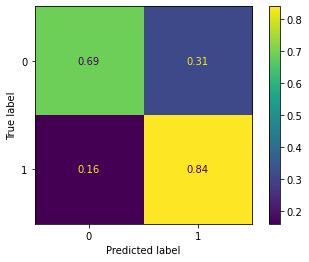

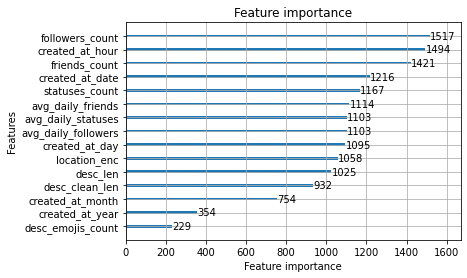

In [28]:
eval_clf(clf_tweets, df_test_tweets)

### Average probas at the user level

AUROC: 0.7482605317679558
Accuracy: 0.7557058326289096


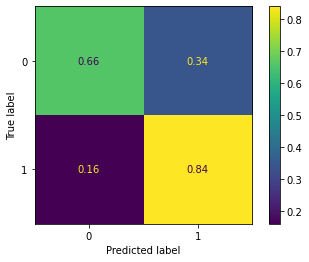

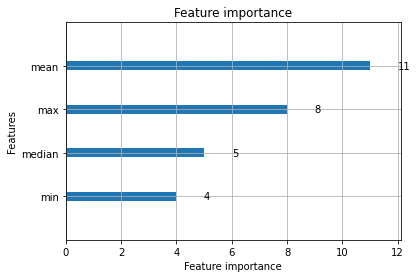

In [31]:
eval_clf(clf_tweets_agg, df_test_tweets_agg)

### Average features at the user level

> Mean

AUROC: 0.7916781767955801
Accuracy: 0.7954353338968724


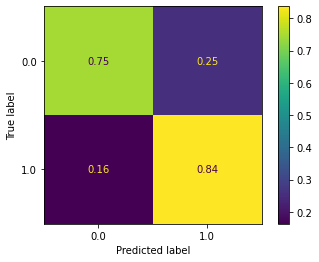

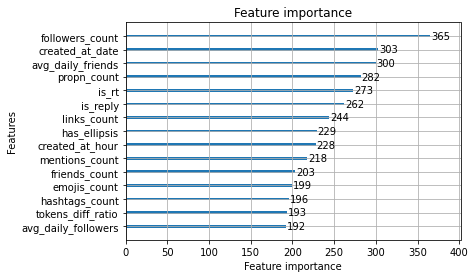

In [34]:
eval_clf(clf_tweets_mean, df_test_tweets_mean)

> Median

AUROC: 0.7829722030386741
Accuracy: 0.7878275570583263


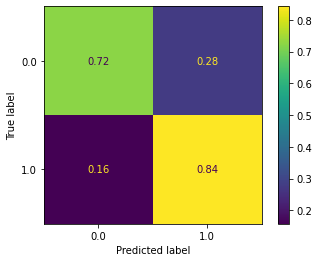

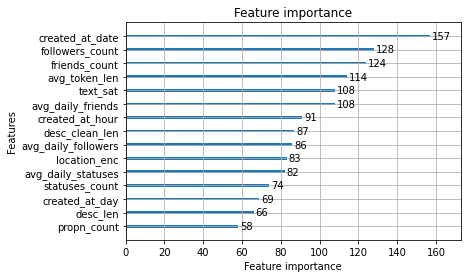

In [36]:
eval_clf(clf_tweets_median, df_test_tweets_median)

## Feature engineering

AUROC: 0.6242186773358023
Accuracy: 0.6275898990808704


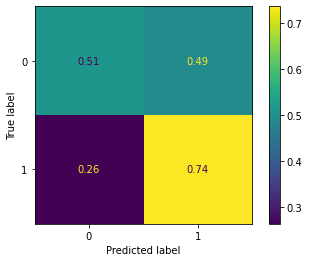

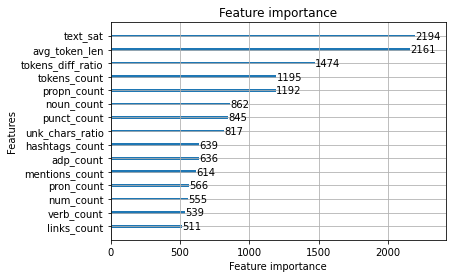

In [49]:
eval_clf(clf_meta_tweet_fe, df_test_meta_tweet_fe)

### Average probas at the user level

AUROC: 0.7320240561694291
Accuracy: 0.7311918850380389


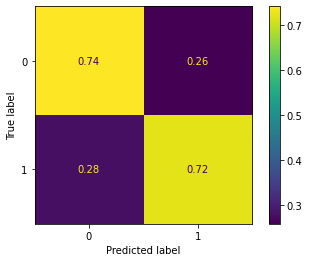

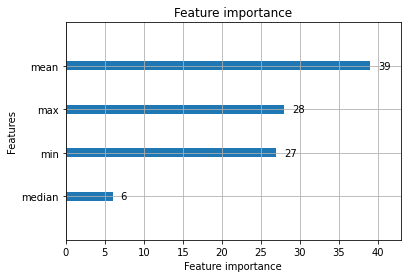

In [51]:
eval_clf(clf_meta_agg_tweet_fe, df_test_meta_agg_tweet_fe)